In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
import networkx as nx

import matplotlib as mpl
from matplotlib import cm
from matplotlib.patches import Circle, Wedge, Polygon
from scipy.spatial.distance import cdist

from ipywidgets import interactive

## Generate data set

In [3]:
N = 100

r = np.random.uniform(-0.2, 0.2, N) # radious
theta = np.random.uniform(-np.pi, np.pi, N) # angles

x = (1+r)*np.cos(theta) # x-corodinate
y = (1+r)*np.sin(theta) # y-coordinate

X = np.column_stack((x,y)) # data set

In [4]:
# Generate data
def dumbbell(N):
    
    r1 = np.random.uniform(0,1,N)
    r2 = np.random.uniform(0,1,N)
    
    theta1 = np.random.uniform(0, 2*np.pi, N)
    theta2 = np.random.uniform(0, 2*np.pi, N)
    
    d1 = np.column_stack((r1*np.cos(theta1), r1*np.sin(theta1)))
    d2 = np.column_stack((3+r2*np.cos(theta2), r2*np.sin(theta2)))
    
    hand = np.column_stack((np.random.uniform(0,3,int(N/10)), np.random.uniform(-0.1,0.1,int(N/10) ) ))
    
    return np.row_stack((d1,d2,hand))
    
X = dumbbell(600)

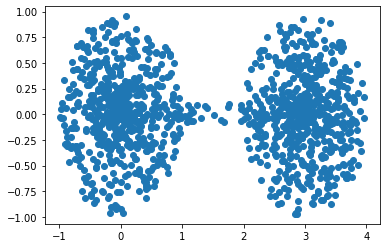

In [5]:
plt.scatter(X[:,0], X[:,1])

In [6]:
distance_matrix = cdist(X,X)

## Landmark selection: minmax subsamplig

In [7]:
# dist_m = distance matrix
# n = number of landmarks
def minmax(dist_m, n):
    L = [np.random.randint(0,len(X))]
    
    dist_to_L = dist_m[ L[-1] ,:]
    
    for i in range(n-1):
        ind = np.argmax( dist_to_L )
        L.append(ind)
        
        dist_to_L = np.minimum(dist_to_L, dist_m[L[-1], :])

    return L, np.max(dist_to_L) + 0.001

Covering radius =  0.2982893518690254


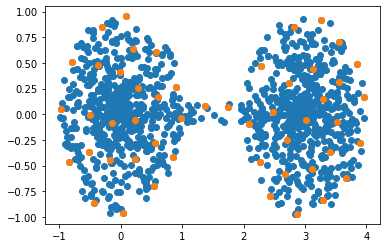

In [8]:
#landamrks contains the indices of the landmark points
#c_r is the minimal covering radious for the landmark set computed.
landmarks, c_r = minmax(distance_matrix, 50) 

print('Covering radius = ', c_r)

# plot
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[landmarks,0], X[landmarks,1])

## Rips and Nerve complexes

In [9]:
# Rips complex
def rips_complex(dist_m, alpha):
    
    D = copy.deepcopy(dist_m)
    
    R = {}
    # 0-simplices
    R['0'] = np.arange(0,len(dist_m))
    
    D[D > alpha] = 0

    non_zero = np.nonzero(D)
    # 1-simplices
    R['1'] = []
    for j in itertools.combinations( np.arange(len(dist_m)), 2 ):
        ind = np.array(j)
        if np.max(dist_m[ind,:][:,ind]) < alpha:
            R['1'].append(ind)
    
    # 2-simplices
    R['2'] = []
    for j in itertools.combinations( np.arange(len(dist_m)), 3 ):
        ind = np.array(j)
        if np.max(dist_m[ind,:][:,ind]) < alpha:
            R['2'].append(ind)

    return R

# Nerve-like complex
def intersection(dist_m, land_ind, epsilon):
    
    distance_to_landmarks = dist_m[land_ind,:]
    
    N = {}
    N['0'] = np.arange(0,len(distance_to_landmarks))
    
    adj_points = np.zeros((len(N['0']), len(N['0'])))
    N['1'] = []
    for j in itertools.combinations( np.arange(len(distance_to_landmarks)), 2 ):
        ind = np.array(j)
        in_ball = distance_to_landmarks[ ind ,:] < epsilon
        if np.logical_and(in_ball[0,:], in_ball[1,:]).any():
            N['1'].append(ind)
            adj_points[ind[0],ind[1]] = np.sum(np.logical_and(in_ball[0,:], in_ball[1,:]))
            adj_points[ind[1],ind[0]] = adj_points[ind[0],ind[1]]
            
    N['2'] = []
    for j in itertools.combinations( np.arange(len(distance_to_landmarks)), 3 ):
        ind = np.array(j)
        in_ball = distance_to_landmarks[ ind ,:] < epsilon
        if np.logical_and(np.logical_and(in_ball[0,:], in_ball[1,:]),in_ball[2,:]).any():
            N['2'].append(ind)
            
    return adj_points, N

In [10]:
# This function generates the slider visualization.
def interactive_plot(alpha):
    landmark_set = X[landmarks,:]
    
    R_a = rips_complex(distance_matrix[landmarks,:][:,landmarks], alpha)
    
    w_by_intersection, N = intersection(distance_matrix, landmarks, alpha)
    
    fig, ax = plt.subplots(2,2, figsize=(30,30))
    
    ax = ax.flatten()
    
    ax[2].scatter(landmark_set[:,0], landmark_set[:,1], c='black')
    ax[2].set_title('Nerve complex')
    for edge in N['1']:
        ax[2].plot(landmark_set[edge,0], landmark_set[edge,1], c='blue')

    for face in N['2']:
        pol = Polygon(landmark_set[face,:], closed=True, color='cyan')
        ax[2].add_patch(pol)
    
    ax[3].scatter(landmark_set[:,0], landmark_set[:,1], c='black')
    ax[3].set_title('Rips complex')
    for edge in R_a['1']:
        ax[3].plot(landmark_set[edge,0], landmark_set[edge,1], c='blue')

    for face in R_a['2']:
        pol = Polygon(landmark_set[face,:], closed=True, color='cyan')
        ax[3].add_patch(pol)

    ax[0].scatter(X[:,0], X[:,1], c='black')
    ax[0].scatter(landmark_set[:,0], landmark_set[:,1], c='red')
    #ax[0].set_ylim(-1-alpha,1+alpha)
    #ax[0].set_xlim(-1-alpha,1+alpha)
    ax[0].set_title('Nerve cover')
    
    for point in range(len(landmarks)):
        cir = Circle((landmark_set[point,0], landmark_set[point,1]), alpha, color=(1,0,0,0.2))
        ax[0].add_patch(cir)
        
    ax[1].scatter(X[:,0], X[:,1], c='black')
    ax[1].scatter(landmark_set[:,0], landmark_set[:,1], c='red')
    #ax[1].set_ylim(-1-alpha,1+alpha)
    #ax[1].set_xlim(-1-alpha,1+alpha)
    ax[1].set_title('Rips cover')
    
    for point in range(len(landmarks)):
        cir = Circle((landmark_set[point,0], landmark_set[point,1]), alpha/2, color=(1,0,0,0.2))
        ax[1].add_patch(cir)
        
inter = interactive(interactive_plot, alpha=(0,2,0.05))
output = inter.children[-1]
inter

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, step=0.05), Output()), _dom_classes…

### The partition of unity

For an open cover given by $\left\{ B_\alpha(l_j) \right\}_{l_j\in L}$, where $L$ is the landmark set and $\alpha$ is the radious of the balls, we have an associated partition of unity defined as

$$ \phi_j(b) = \frac{\vert \alpha - d(b,l_j) \vert_+}{\sum\limits_{k} \vert \alpha - d(b,l_k) \vert_+} $$ 

where $\vert x \vert_+ = \max\{x,0\}$.

In [11]:
# Partition of unity
def partition_unity(dist_m, land_ind, alpha):
    
    dist_matrix = dist_m[land_ind,:]
    
    max_matrix = np.maximum(alpha-dist_matrix, 0)

    total = np.sum(max_matrix, axis=0)
    
    if np.isnan(np.divide(max_matrix, total)).any():
        print('WARNING: Some points are not in the cover.')
    
    values_of_partition = np.nan_to_num(np.divide(max_matrix, total))
    
    return values_of_partition

## Activity: 

provide an appropiate radious ($\alpha$), such that the corresponding balls centered at the selected landmarks cover the data set. 

Points per ball =  [183  51  28  42  59  47  65 283  54  36  67  65  64 278  50  56  55  43
 226 190 184 154 170 133  33  52 133 100  57  38 134 241 120  76 135  26
  44 301 166  59 120  42 253  40  57 241  74 149 108 254]
Is it a partiton of 1 ->  True


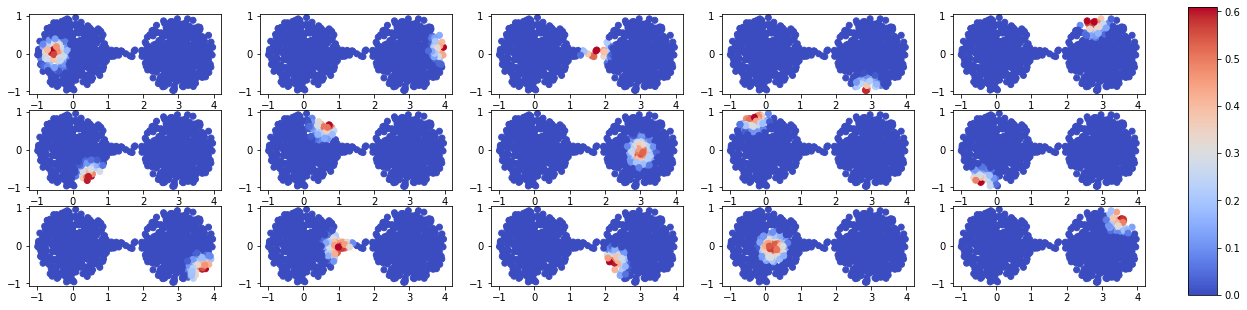

In [12]:
radious = 0.48

phi = partition_unity(distance_matrix, landmarks, radious)

print('Points per ball = ',np.sum(phi!=0, 1))
print('Is it a partiton of 1 -> ', np.sum(phi)==len(X))

# Plot: scatter plot of the data set solored by different functions in the parttion of unity.
fig, ax = plt.subplots(3, 5, figsize=(20,5))

ax = ax.flatten()

for i in range(15):
    im = ax[i].scatter(X[:,0], X[:,1], c=phi[i,:], cmap='coolwarm', marker='o')
    
cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

## Weighted graph from Nerve complex

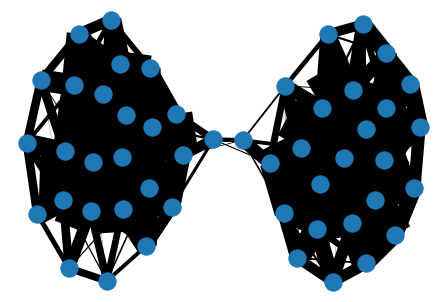

In [13]:
#w_by_intersection = matric that contains the number of points in each intersection
#nerve = Nerve complex on the landmark set, up to simplicas of dim 2
w_by_intersection, nerve = intersection(distance_matrix, landmarks, radious)

# w_by_distance = distance amtrix for the landmark set
w_by_distance = distance_matrix[landmarks,:][:,landmarks]

# Compute the weights for the graph underlying the nerve complex
weights = np.zeros((len(nerve['0']), len(nerve['0'])))
positions = w_by_intersection > 0
weights[positions] = np.divide(w_by_intersection[positions], w_by_distance[positions])/np.sqrt(N)

# Graph initialization
G = nx.from_numpy_matrix(weights)

# plot
thickness = weights[np.triu_indices(len(weights), k = 1)]
thickness = thickness[thickness > 0]
nx.draw(G, pos=X[landmarks,:], width=2*thickness)

## Graph Laplacian

$$ L = D - W $$

$$ D_{i,i} = \sum\limits_{k=1}^N W_{i,k} \text{ and } D_{i,j} = 0 \text{ for all } i\neq j$$

Eigenvalues: [ 3.39927435e+02  2.94286310e+02  3.15680161e+02  2.57390808e+02
  2.63998614e+02  2.13952585e+02  1.93333264e+02  1.74644251e+02
  1.72874055e+02  1.80888089e+02  1.48085912e+02  1.34183751e+02
  1.44343006e+02  1.42146599e+02  1.29265700e+02  1.05028186e+02
  1.12031160e+02  1.00095277e+02  9.15158180e+01  8.15288431e+01
  7.46910653e+01  8.29730028e+01 -1.98202305e-14  1.71408572e-01
  9.03531072e+00  1.13789664e+01  1.29055932e+01  5.72123696e+01
  5.45541297e+01  5.47140331e+01  5.24622276e+01  4.80936851e+01
  4.89609251e+01  4.73588746e+01  1.49939135e+01  1.64814435e+01
  1.83286806e+01  1.95072945e+01  2.06551292e+01  4.15820850e+01
  3.96030039e+01  2.23342809e+01  2.49466434e+01  3.69029027e+01
  3.66559989e+01  2.67390773e+01  3.25257596e+01  3.30480113e+01
  3.05953404e+01  2.99654581e+01]
Eigenvector: [[ 5.87416756e-02  1.37370864e-01  2.60407606e-09 ... -1.48913194e-04
   7.86777196e-03 -4.40867472e-05]
 [-2.42776053e-11  2.38270126e-10 -5.23079591e-03 ...  

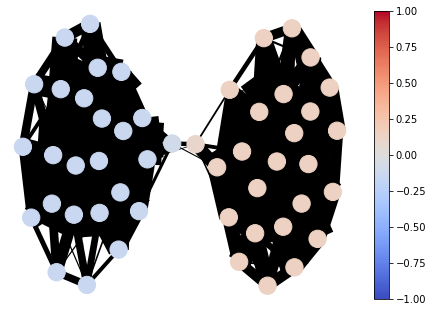

In [14]:
D = np.diag(np.sum(weights, axis=0))
L = D - weights

eig_val, eig_vec = np.linalg.eig(L)

print('Eigenvalues:', eig_val)

ind_sorted_eigval = np.argsort(eig_val)

# Choose an eigenvector
ind_eig = 1
eigvec = eig_vec[:, ind_sorted_eigval[ind_eig]]

print('Eigenvector:', eig_vec)

nx.draw(G, pos=X[landmarks,:], width=2*thickness, node_color=eigvec, cmap='coolwarm', vmin=-1, vmax=1)

norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)

sm = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
sm._A = []
plt.colorbar(sm)

## Extending laplacian eigenvector to data using the partition of unity

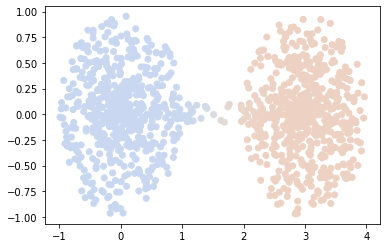

In [15]:
# this function maps each point in the data set to a colormap using a vector of node values
def coloration(X, partition_of_1, vector):
  
    norm_vec = (vector + 1)/2
    
    red = np.array([1,0,0,1])
    blue = np.array([0,0,1,1])
    
    c = []
    for i in range(len(X)):
        phi_x = partition_of_1[:,i]
        t = np.dot(phi_x, norm_vec)
        
        c.append( cm.coolwarm(int(255*t)) ) 
    
    return np.asarray(c)
    
col = coloration(X, phi, eigvec)

plt.scatter(X[:,0],X[:,1], c=col)

## Unsupervised classification problem:

For this activity we will generate a data set from a ''dumbbell''.

In [16]:
# Generate data
def dumbbell(N):
    
    r1 = np.random.uniform(0,1,N)
    r2 = np.random.uniform(0,1,N)
    
    theta1 = np.random.uniform(0, 2*np.pi, N)
    theta2 = np.random.uniform(0, 2*np.pi, N)
    
    d1 = np.column_stack((r1*np.cos(theta1), r1*np.sin(theta1)))
    d2 = np.column_stack((3+r2*np.cos(theta2), r2*np.sin(theta2)))
    
    hand = np.column_stack((np.random.uniform(0,3,int(N/10)), np.random.uniform(-0.1,0.1,int(N/10) ) ))
    
    return np.row_stack((d1,d2,hand))
    
data = dumbbell(600)

# Distance matrix

# Landmarks


In [17]:
data.shape

(1260, 2)

## Activity:

Complete the code in the cell bellow, so that the extended eigenvectrs of the graph laplacian on the landmarks separate the two ends of the dumbbell.

In [18]:
# Partition of unity



# Weightes graph



# Graph Laplacian


# Laplacian eigenvectors



# Choose an eigenvector



# Plot the graph with colored nodes corresponding to the choosen eigenvector.



# Plot the data with points colored by the extended eigenvector.





In [19]:
import ipyvolume as ipv
import numpy as np
N = 1000
x, y, z = np.random.normal(0, 1, (3, N))

fig = ipv.figure()
scatter = ipv.scatter(x, y, z)
ipv.show()

ModuleNotFoundError: No module named 'ipyvolume'